In [10]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# Drawing Utils

In [99]:
def ImageLayout(dic, double=False, save=False, path='Demo.png'):
    dx = 55
    dy = 130
    dnext = 135
    dright = 60
    img = plt.imread('BlankLayout.png')
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(img)
    it = 0
    iniX = 180
    iniY = 250

    X = iniX
    Y = iniY
    for i in range(10):
        X2 = X
        Y2 = Y
        for j in range(4):
            ax.text(X2, Y2, str(dic[it]))
            it += 1
            if double == True:
                ax.text(X2+dright, Y2, str(dic[it]))
            it+=1
            X2 += dx
            Y2 += dy
        X+= dnext

    X2 = X
    Y2 = Y
    for j in range(3):
        ax.text(X2, Y2, str(dic[it]))
        it += 1
        if double == True:
            ax.text(X2+dright, Y2, str(dic[it]))
        it+=1
        X2 += dx
        Y2 += dy
    X+= dnext


    X2 = X
    Y2 = Y
    for j in range(2):
        ax.text(X2, Y2, str(dic[it]))
        it += 1
        if double == True:
            ax.text(X2+dright, Y2, str(dic[it]))
        it+=1
        X2 += dx
        Y2 += dy
    X+= dnext

    X2 = X +dx
    Y2 = Y + dy
    ax.text(X2, Y2, str(dic[it]))
    it += 1
    if double == True:
        ax.text(X2+dright, Y2, str(dic[it]))
    it+=1

    X2 = iniX-dnext
    Y2 = iniY
    ax.text(X2, Y2, str(dic[it]))
    it += 1
    if double == True:
        ax.text(X2+dright, Y2, str(dic[it]))
    it+=1

    if save == True:
        fig.savefig(path, dpi= 1000)
    


# Objective Function

In [11]:
class FunctionHelper:
    def __init__(self, charMap, charCount, pairCount):
        self.charMap = charMap
        self.charCount = charCount
        self.pairCount = pairCount
        self.FINGERS_NAME = ['pinky', 'ring', 'middle', 'index', 'thumb', 'none', 'unknown']
        self.FINGERS = [0,1,2,3,4,5,6]
        self.FINGERS_WEIGHT = [3,2, 2, 1, 0, 0, 'Unknown']
        self.HAND = ['left', 'right', 'none', 'Unknown']
        self.COLUMNS = [0,1,2,3,'Unknown']
        self.COLUMNS_WEIGHT = [2,1,0,1.5,'Unknown']
        self.MOVEMENT = [0, 1, 2, 3, 'Unknown']

    def getCSVIndex(self,c):
        return self.charMap[c]
    
    def GetFinger(self,index):
        if(index >= 0 and index <= 9):
            return self.FINGERS[0]
        if(index >= 10 and index <= 17):
            return self.FINGERS[1]
        if(index >= 18 and index <= 25):
            return self.FINGERS[2]
        if(index >= 26 and index <= 41):
            return self.FINGERS[3]
        if(index >= 42 and index <= 55):
            return self.FINGERS[3]
        if(index >= 56 and index <= 63):
            return self.FINGERS[2]
        if(index >= 64 and index <= 71):
            return self.FINGERS[1]
        if(index >= 72 and index <= 93):
            return self.FINGERS[0]
        return self.FINGERS[-1]

    def GetHand(self, index):
        if(index >= 0 and index <= 41):
            return self.HAND[0]
        if(index >= 92 and index <= 93):
            return self.HAND[0]
        if(index >= 42 and index <= 91):
            return self.HAND[1]
        return self.HAND[-1]

    def ShiftHand(self, index):
        if(index%2 == 0):
            return self.HAND[2]
        if(self.GetHand(index) == self.HAND[0]):
            return self.HAND[1]
        if(self.GetHand(index) == self.HAND[1]):
            return self.HAND[0]
        return self.HAND[-1]

    def Column(self, index):
        if(index <= 85):
            ii = index%8
            if(ii == 0 or ii == 1):
                return self.COLUMNS[0]
            if(ii == 2 or ii == 3):
                return self.COLUMNS[1]
            if(ii == 4 or ii == 5):
                return self.COLUMNS[2]
            if(ii == 6 or ii == 7):
                return self.COLUMNS[3]
        
        if(index > 85):
            ii = index%8
            if(ii == 0 or ii == 1):
                return self.COLUMNS[1]
            if(ii == 2 or ii == 3):
                return self.COLUMNS[1]
            if(ii == 4 or ii == 5):
                return self.COLUMNS[0]
            if(ii == 6 or ii == 7):
                return self.COLUMNS[0]
        return self.COLUMNS[-1]

    def LateralMovement(self, index):
        index = index - (index%2)
        if(index == 0):
            return self.MOVEMENT[1]
        if(index == 92):
            return self.MOVEMENT[2]
        if(index == 90):
            return self.MOVEMENT[3]
        if(index >= 86 and index <= 88):
            return self.MOVEMENT[2]
        if(index >= 80 and index <= 84):
            return self.MOVEMENT[1]
        if(index >= 34 and index <= 46):
            return self.MOVEMENT[1]
        if(index >= 0 and index <= 93):
            return self.MOVEMENT[0]
        return self.MOVEMENT[-1]

    def WeightIndex(self, index):
        assert (index <= 93)
        finger = self.GetFinger(index)
        wFinger = self.FINGERS_WEIGHT[finger]
        lat = self.LateralMovement(index)
        colW = self.COLUMNS_WEIGHT[self.Column(index)]
        return ((lat+colW)**2)*wFinger 
    
    def LeftShift(self, indexA):
        ha = self.GetHand(indexA)
        hb = self.GetHand(6)
        if(ha != hb): return 0
        fa = self.GetFinger(indexA)
        cola = self.Column(indexA)
        lata = self.LateralMovement(indexA)
        fb = self.GetFinger(6)
        colb = self.Column(6)
        latb = self.LateralMovement(3)
        if(fa == fb):
            return ((cola-colb)**2+(lata-latb)**2) * 10 * self.FINGERS_WEIGHT[fa]
        return ((cola-colb)**2) * (self.FINGERS_WEIGHT[fa] + self.FINGERS_WEIGHT[fb])

    def RightShift(self, indexA):
        ha = self.GetHand(indexA)
        hb = self.GetHand(78)
        if(ha != hb): return 0
        fa = self.GetFinger(indexA)
        cola = self.Column(indexA)
        lata = self.LateralMovement(indexA)
        fb = self.GetFinger(78)
        colb = self.Column(78)
        latb = self.LateralMovement(78)
        if(fa == fb):
            return ((cola-colb)**2+(lata-latb)**2) * 10 * self.FINGERS_WEIGHT[fa]
        return ((cola-colb)**2) * (self.FINGERS_WEIGHT[fa] + self.FINGERS_WEIGHT[fb])

    def WeightPairWise(self, indexA, indexB):
        if(indexA%2 == 1 and indexB%2 == 1):
            iA = indexA-1
            iB = indexB-1
            ans = self.WeightPairWise(iA, iB)
            ha = self.GetHand(indexA)
            if(ha == self.HAND[1]):
                ans += self.LeftShift(iB)
            else:
                ans += self.RightShift(iB)
            
            hb = self.GetHand(indexB)
            if(hb == self.HAND[1]):
                ans += self.LeftShift(iA)
            else:
                ans += self.RightShift(iA)
            return ans
        if(indexA%2 == 1):
            iA = indexA-1
            iB = indexB
            ans = self.WeightPairWise(iA, iB)
            ha = self.GetHand(indexA)
            if(ha == self.HAND[1]):
                ans += self.LeftShift(iB)
            else:
                ans += self.RightShift(iB)
            return ans
        if(indexB%2 == 1):
            return self.WeightPairWise(indexB, indexA)


        ha = self.GetHand(indexA)
        hb = self.GetHand(indexB)
        if(ha != hb): return 0
        fa = self.GetFinger(indexA)
        cola = self.Column(indexA)
        lata = self.LateralMovement(indexA)
        fb = self.GetFinger(indexB)
        colb = self.Column(indexB)
        latb = self.LateralMovement(indexB)
        if(fa == fb):
            return ((cola-colb)**2+(lata-latb)**2) * 10 * self.FINGERS_WEIGHT[fa]
        return ((cola-colb)**2) * (self.FINGERS_WEIGHT[fa] + self.FINGERS_WEIGHT[fb])
    

In [12]:
def ObjectiveFunction(X, helper):
    ans = 0
    chars = 0
    XIndex = [helper.getCSVIndex(x) for x in X]
    for i, x in enumerate(XIndex):
        ans += helper.charCount[x]*helper.WeightIndex(i)
        chars += helper.charCount[x]
    for i,x in enumerate(XIndex):
        for j,y in enumerate(XIndex):
            ans += helper.pairCount[x][y]*helper.WeightPairWise(i,j)
            chars += helper.pairCount[x][y]
    return ans/chars
        

In [13]:
validChars = 'pPyYfFgGcCrRlLaAoOeEuUiIdDhHtTnNsSqQjJkKxXbBmMwWvVzZ$&[{}(=*)+]!#~%7531902468`;,./@\\:<>?^|-\'_"\t\n '
allChars = dict(zip(validChars,np.arange(len(validChars))))
charCountCSV = np.array(pd.read_csv('CharCount.csv').values)[:,2]
pairCountCSV = np.array(pd.read_csv('PairCount.csv').values)[:,1:]

In [14]:
helper = FunctionHelper(allChars, charCountCSV, pairCountCSV)

In [15]:
qwertyLayout = '1!qQaAzZ2@wWsSxX3#eEdDcC4$rRfFvV5%tTgGbB6^yYhHnN7&uUjJmM8*iIkK,<9(oOlL.>0)pP;:/?-_[{\'"=+]}\\|`~'
baseLayout = 'pPyYfFgGcCrRlLaAoOeEuUiIdDhHtTnNsSqQjJkKxXbBmMwWvVzZ$&[{}(=*)+]!#~%7531902468`;,./@\\:<>?^|-\'_"'
print(len(qwertyLayout))

94


In [16]:
funVal = ObjectiveFunction(qwertyLayout, helper)
print(funVal)

9.627145681198524


In [17]:
funVal = ObjectiveFunction(baseLayout, helper)
print(funVal)

15.212302700036597


# Genetic Algorithm Functions

26 lowercase letters
52 letters
94 characters

In [26]:
randGen = np.random.default_rng(16072001)

In [118]:

def GenerateRandomIndividual(gen, validChars):
    individual = np.ones(94)*-1
    lowercase = gen.permutation(47)[:26]
    lowercase *= 2
    for i, x in zip(range(0,52,2), lowercase):
        individual[x] = i
        individual[x+1] = i+1
    
    restChars = gen.permutation(94-52)
    restChars += 52
    itInd = 0
    for x in restChars:
        while(individual[itInd] != -1):
            itInd+=1
        individual[itInd] = x
        itInd += 1
    ans = [validChars[int(x)] for x in individual]
    return np.array(ans)




In [161]:
XRandom = GenerateRandomIndividual(randGen, validChars)
XRandom

array(['"', '<', 'o', 'O', 'k', 'K', 'z', 'Z', '.', '_', 'q', 'Q', 'g',
       'G', '3', '=', 'h', 'H', '?', '5', 'w', 'W', '+', '4', 'v', 'V',
       ']', '\\', 'b', 'B', 'r', 'R', 'd', 'D', 'c', 'C', 'p', 'P', 'e',
       'E', '`', '!', '#', '0', 'a', 'A', 'f', 'F', 'y', 'Y', 't', 'T',
       '@', '|', ':', '6', 'n', 'N', "'", '{', '~', '*', ';', ')', '-',
       '&', 'm', 'M', '%', '9', '^', '8', '7', '}', 'u', 'U', 'x', 'X',
       '[', '2', ',', '>', 's', 'S', 'i', 'I', 'l', 'L', '$', '(', 'j',
       'J', '/', '1'], dtype='<U1')

In [162]:
ObjectiveFunction(XRandom, helper)

17.29825053392074

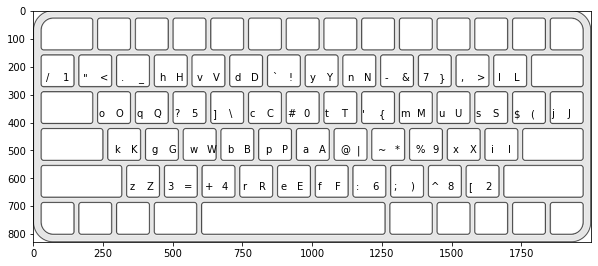

In [163]:
ImageLayout(XRandom, True)

In [164]:
def SwapMutation(X, gen, allChars):
    #Swap two keys
    a = int(gen.random()*47)
    b = int(gen.random()*47)
    a*=2
    b*=2
    a = int(a)
    b = int(b)
    aa = X[a]
    aa2 = X[a+1]
    X[a] = X[b]
    X[a+1] = X[b+1]
    X[b+1] = aa2
    X[b] = aa

    #Swap in same key
    a = int(gen.random()*(47-26))
    a*=2
    for i, x in enumerate(X):
        if(a == 0 and allChars[x] >= 52):
            print(i)
            t = X[i]
            X[i] = X[i+1]
            X[i+1] = t
            break
        elif(allChars[x]>=52):
            a-=1
    return X


In [168]:
Prev = XRandom.copy()
XNew = SwapMutation(XRandom, randGen, allChars)
print(ObjectiveFunction(XNew, helper), ObjectiveFunction(Prev, helper))

58
16.863851629209663 17.010757148778342


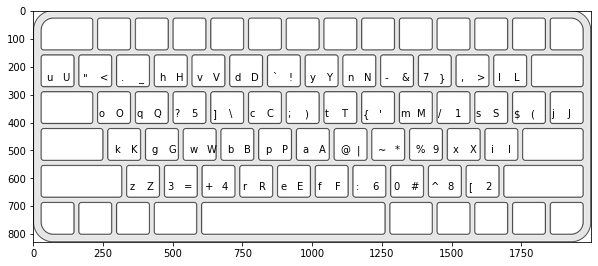

In [169]:
ImageLayout(XNew, True)

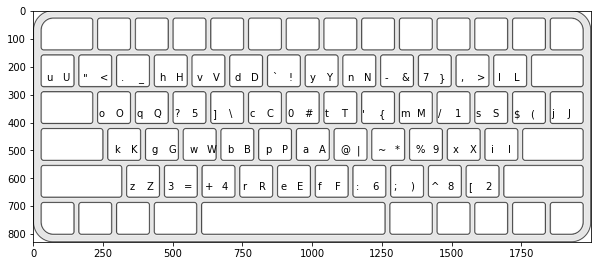

In [170]:
ImageLayout(Prev, True)

In [186]:
def CrossOver(pa, pb, rng, allChars):
    div = int(rng.random()*47)
    div*=2
    son = pa.copy()
    son[:div] = pa[:div]
    dic = dict()
    for i in range(div):
        dic[pa[i]] = 1

    extra = []
    extraLetter = []
    for j in range(div):
        if(dic.get(pb[j]) is None):
            if(allChars[pb[j]] < 52):
                extraLetter.append(pb[j])
            else:
                extra.append(pb[j])
    
    son[div:] = pb[div:]
    itExtra = 0
    itExtraLetter = 0
    for i in range(div, 94):
        if(dic.get(son[i]) is not None):
            if((i%2 == 0 and itExtraLetter < len(extraLetter)) or itExtraLetter%2 == 1):
                son[i] = extraLetter[itExtraLetter]
                itExtraLetter+=1
            else:
                son[i] = extra[itExtra]
                itExtra += 1

    return son

In [187]:
X1 = GenerateRandomIndividual(randGen, validChars)
X2 = GenerateRandomIndividual(randGen,validChars)
Y = CrossOver(X1, X2, randGen, allChars)
print(ObjectiveFunction(X1, helper), ObjectiveFunction(X2, helper) ,ObjectiveFunction(Y, helper))


['o' 'O' '2' ':' 'c' 'C' '}' "'" 'y' 'Y' '/' '5' 'a' 'A' 'm' 'M' 'k' 'K'
 '9' '!' '^' '6' 'e' 'E' 's' 'S' ',' '(' '>' '7' '&' '~' 'h' 'H' 'w' 'W'
 '1' '@' ')' '8' ';' '-' '%' '\\' 'g' 'G' '{' '[' 'l' 'L' 'p' 'P' 'f' 'F'
 'b' 'B' '+' '|' 'r' 'R' 'q' 'Q' 'j' 'J' '#' '?' 'i' 'I' '3' '.' 't' 'T'
 'd' 'D' 'z' 'Z' '_' '=' '4' ']' '*' '0' 'x' 'X' '<' '$' '"' '`' 'u' 'U'
 'n' 'N' 'v' 'V']
['o' 'O' '2' ':' 'c' 'C' '}' "'" 'y' 'Y' '/' '5' 'a' 'A' 'm' 'M' 'k' 'K'
 '9' '!']
19.072633969209598 15.501931887640511 16.524521608779672
